In [1]:
import os 
import timm
import torch
import torch
import torch.nn as nn
import requests
import timm
import math
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt

In [2]:
from multissl.models import FastSiam

In [3]:
def clean_state_dict(
    state_dict,
    prefix_to_strip="backbone.",
    skip_if_contains=None
):
    """
    Create a new state_dict with:
      1) The specified prefix stripped from the start of each key.
      2) Certain keys *entirely removed* if they match a skip pattern.

    :param state_dict: (dict) The original state_dict.
    :param prefix_to_strip: (str) If a key starts with this prefix, remove that prefix.
    :param skip_if_contains: (list of str or None)
            If not None, any key containing ANY of these substrings is skipped entirely.
    :return: (dict) A new state_dict with modified/filtered keys.
    """
    if skip_if_contains is None:
        skip_if_contains = []

    new_state_dict = {}
    for key, value in state_dict.items():
        # 1) Check if we should skip this key entirely
        #    (if the key contains any of the "skip" substrings)
        if any(skip_str in key for skip_str in skip_if_contains):
            continue

        # 2) Strip prefix if present
        if key.startswith(prefix_to_strip):
            new_key = key[len(prefix_to_strip):]
        else:
            new_key = key

        new_state_dict[new_key] = value

    return new_state_dict


In [4]:
from multissl.data import tifffile_loader
from multissl.data.transforms import UIntToFloat, Transpose, ToTensor
from torchvision import transforms
import cv2

def load_tiff_tensor(path, image_size=None):
    """
    Load a TIFF file, optionally resize to (image_size, image_size), 
    then run through the transform pipeline to get a PyTorch tensor.
    """
    # 1) Read as NumPy array
    image_array = tifffile_loader(path)  # shape could be H×W or H×W×C
    
    # 2) Optionally resize if image_size is given
    if image_size is not None:
        # If image_array is (H, W) or (H, W, C), handle both
        if image_array.ndim == 2:
            # Grayscale => H×W
            image_array = cv2.resize(image_array, (image_size, image_size),
                                     interpolation=cv2.INTER_AREA)
        elif image_array.ndim == 3:
            # Color => H×W×C
            # Note cv2.resize wants (W, H) as the second argument
            h, w, c = image_array.shape
            image_array = cv2.resize(image_array, (image_size, image_size),
                                     interpolation=cv2.INTER_AREA)
        else:
            raise ValueError(f"Unsupported shape {image_array.shape}.")
    base = [UIntToFloat(), Transpose(), ToTensor()]
    # 3) Apply transform pipeline (normalization, transpose, tensor)
    pipeline = transforms.Compose(base) 
      # shape will end up as (C, H, W)
    
    return pipeline(image_array).unsqueeze(0), image_array
    

# Segmentation Head definition and training

In [40]:
# Import necessary libraries
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from timm import create_model
from einops import rearrange
import torch.nn as nn
import torch.nn.functional as F
import tifffile as tiff
from torchvision import transforms
import cv2
from tqdm.notebook import tqdm

# Set seed for reproducibility
pl.seed_everything(42)

Seed set to 42


42

In [112]:

class SimpleViTFeatureExtractor(nn.Module):
    """
    A simple feature extractor that captures outputs from specific transformer blocks
    """
    def __init__(self, vit_model, layer_indices=(3, 7, 11)):
        super().__init__()
        self.vit = vit_model
        self.layer_indices = layer_indices
        self.features = {i: None for i in layer_indices}
        
        # Register hooks to capture outputs from specified layers
        for i, block in enumerate(vit_model.blocks):
            if i in layer_indices:
                block.register_forward_hook(self._create_hook(i))
    
    def _create_hook(self, i):
        def hook(module, input, output):
            # Store the output tensor from the transformer block
            self.features[i] = output
        return hook
    
    def forward(self, x):
        # Clear previous features
        for i in self.layer_indices:
            self.features[i] = None
            
        # Forward pass through ViT
        output = self.vit(x)
        
        # Return both the final output and the intermediate features
        return output, self.features


class SimpleSegmentationHead(nn.Module):
    """
    A simple segmentation head that directly uses features from different ViT layers
    """
    def __init__(self, in_channels, num_classes, img_size=224, patch_size=16):
        super().__init__()
        
        self.in_channels = in_channels
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        
        # Projections for features from each layer
        self.projections = nn.ModuleList([
            nn.Conv2d(in_channels, 256, kernel_size=1)
            for _ in range(3)  # Assuming 3 layers by default
        ])
        
        # Fusion layer to combine multi-layer features
        self.fusion = nn.Sequential(
            nn.Conv2d(256 * 3, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # Decoder network
        self.decoder = nn.Sequential(
            # First upsampling stage
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            
            # Second upsampling stage
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            
            # Final conv stages
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )
    
    def _reshape_transformer_output(self, x, batch_size):
        """
        Reshape transformer output to spatial feature map
        """
        # Handle different output formats
        if x.dim() == 2:
            # [B, C] format - reshape to [B, C, 1, 1] and upsample
            x = x.view(batch_size, -1, 1, 1)
            x = F.interpolate(x, size=(self.grid_size, self.grid_size), mode='bilinear', align_corners=False)
        elif x.dim() == 3:
            # [B, N, C] format - convert to spatial feature map
            if x.size(1) == (self.grid_size * self.grid_size) + 1:
                # Remove class token if present
                x = x[:, 1:, :]
            
            # Reshape to spatial dimensions [B, C, H, W]
            x = x.reshape(batch_size, self.grid_size * self.grid_size, -1)
            x = x.permute(0, 2, 1)
            x = x.reshape(batch_size, self.in_channels, self.grid_size, self.grid_size)
        
        return x
    
    def forward(self, features_dict):
        """
        Forward pass using features extracted from different transformer layers
        """
        # Get batch size from first feature
        first_key = list(features_dict.keys())[0]
        batch_size = features_dict[first_key].shape[0]
        
        # Process features from each layer
        processed_features = []
        for i, layer_idx in enumerate(sorted(features_dict.keys())):
            # Get features for this layer
            feat = features_dict[layer_idx]
            
            # Reshape to spatial format
            spatial_feat = self._reshape_transformer_output(feat, batch_size)
            
            # Apply projection
            proj_feat = self.projections[i](spatial_feat)
            
            # Make sure all feature maps have the same size
            if proj_feat.shape[2:] != (self.grid_size, self.grid_size):
                proj_feat = F.interpolate(
                    proj_feat, 
                    size=(self.grid_size, self.grid_size), 
                    mode='bilinear', 
                    align_corners=False
                )
            
            processed_features.append(proj_feat)
        
        # Concatenate features from all layers
        concat_features = torch.cat(processed_features, dim=1)
        
        # Apply fusion
        fused = self.fusion(concat_features)
        
        # Apply decoder to get final segmentation map
        segmentation = self.decoder(fused)
        
        # Make sure output is at the desired image resolution
        if segmentation.shape[2:] != (self.img_size, self.img_size):
            segmentation = F.interpolate(
                segmentation, 
                size=(self.img_size, self.img_size), 
                mode='bilinear', 
                align_corners=False
            )
        
        return segmentation


class ViTSegmentationModel(pl.LightningModule):
    """
    Complete model combining ViT backbone with a simple segmentation head
    """
    def __init__(
        self, 
        backbone, 
        num_classes, 
        img_size=224, 
        patch_size=16, 
        lr=1e-3, 
        weight_decay=1e-5,
        layer_indices=(3, 7, 11),
        freeze_backbone=True
    ):
        super().__init__()
        
        # Store backbone information
        self.backbone_dim = backbone.num_features  # Usually 384 for ViT-S/16
        
        # Feature extractor to get intermediate outputs from specific layers
        self.feature_extractor = SimpleViTFeatureExtractor(
            vit_model=backbone,
            layer_indices=layer_indices
        )
        self.backbone = self.feature_extractor.vit
        
        # Freeze backbone if specified
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Segmentation head
        self.seg_head = SimpleSegmentationHead(
            in_channels=self.backbone_dim,
            num_classes=num_classes,
            img_size=img_size,
            patch_size=patch_size
        )
        
        # Training parameters
        self.lr = lr
        self.weight_decay = weight_decay
        self.freeze_backbone = freeze_backbone
        self.save_hyperparameters(ignore=['backbone'])
    
    def forward(self, x):
        # Extract features from backbone
        _, features = self.feature_extractor(x)
        
        # Apply segmentation head
        segmentation_map = self.seg_head(features)
        
        return segmentation_map

    def dice_loss(self, outputs, targets, smooth=1.0):
        num_classes = outputs.size(1)
        
        # One-hot encode targets
        targets_one_hot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()
        
        # Apply softmax to get probabilities
        probs = F.softmax(outputs, dim=1)
        
        # Calculate Dice loss
        intersection = (probs * targets_one_hot).sum(dim=(0, 2, 3))
        union = probs.sum(dim=(0, 2, 3)) + targets_one_hot.sum(dim=(0, 2, 3))
        
        dice_score = (2.0 * intersection + smooth) / (union + smooth)
        
        # Focus more on vine class (class 1)
        class_weights = torch.tensor([0.5, 1.5], device=outputs.device)
        weighted_dice = dice_score * class_weights
        
        return 1.0 - weighted_dice.mean()
        
    def combined_loss(self, outputs, targets, ce_weight=0.5, dice_weight=0.5):
        # Define class weights for CE loss
        class_weights = torch.tensor([1.0, 3.0], device=outputs.device)
        
        # Calculate CE loss
        ce_loss = F.cross_entropy(outputs, targets, weight=class_weights)
        
        # Calculate Dice loss
        dice = self.dice_loss(outputs, targets)
        
        # Combine losses
        return ce_weight * ce_loss + dice_weight * dice
    
    def training_step(self, batch, batch_idx):
        """Training step with mixed dice, weighted cross-entropy loss"""
        images, masks = batch
        logits = self(images)

        # Dice loss for segmentation
        loss = self.combined_loss(logits, masks)
        
        # Log metrics
        self.log("train_loss", loss, prog_bar=True)
        
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        """Validation step with metrics calculation"""
        images, masks = batch
        logits = self(images)
        
        # Cross entropy loss
        loss = F.cross_entropy(logits, masks)
        
        # Calculate IoU or other metrics if needed
        # Here's a simple pixel accuracy calculation
        preds = torch.argmax(logits, dim=1)
        accuracy = (preds == masks).float().mean()
        
        # Log metrics
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", accuracy, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        """Configure optimizer with potential different LRs for backbone and head"""
        # Option 1: Single optimizer for all parameters (simpler)
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        
        # Learning rate scheduler (optional)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.5, 
            patience=5,
            verbose=True
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch"
            }
        }
    
    def unfreeze_backbone(self, fine_tune_layers=None):
        """
        Unfreeze backbone layers for fine-tuning
        Args:
            fine_tune_layers: List of layer indices to unfreeze, or None to unfreeze all
        """
        if fine_tune_layers is None:
            # Unfreeze all backbone parameters
            for param in self.backbone.parameters():
                param.requires_grad = True
        else:
            # Unfreeze only specific layers (e.g., last few blocks of ViT)
            # This is specific to ViT architecture and might need adjustment
            for i, block in enumerate(self.backbone.blocks):
                if i in fine_tune_layers:
                    for param in block.parameters():
                        param.requires_grad = True
    def test_step(self, batch, batch_idx):
        """
        Run test step on a single batch
        """
        images, masks = batch
        
        # Forward pass
        logits = self(images)
        
        # Cross entropy loss
        loss = F.cross_entropy(logits, masks)
        
        # Get predictions
        preds = torch.argmax(logits, dim=1)
        
        # Calculate accuracy
        accuracy = (preds == masks).float().mean()
        
        # Initialize metrics per class
        num_classes = logits.shape[1]
        metrics_per_class = []
        confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.long, device=self.device)
        
        # Calculate metrics for each class and build confusion matrix
        for i in range(num_classes):
            for j in range(num_classes):
                confusion_matrix[i, j] = ((preds == j) & (masks == i)).sum()
        
        for c in range(num_classes):
            # True positives, false positives, false negatives
            true_pos = ((preds == c) & (masks == c)).sum().float()
            false_pos = ((preds == c) & (masks != c)).sum().float()
            false_neg = ((preds != c) & (masks == c)).sum().float()
            
            # Calculate metrics, avoiding division by zero
            precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else torch.tensor(0.0, device=self.device)
            recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else torch.tensor(0.0, device=self.device)
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else torch.tensor(0.0, device=self.device)
            
            # Calculate IoU (Intersection over Union) for this class
            iou = true_pos / (true_pos + false_pos + false_neg) if (true_pos + false_pos + false_neg) > 0 else torch.tensor(0.0, device=self.device)
            
            metrics_per_class.append({
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'iou': iou
            })
        
        # Calculate overall metrics (micro average across all classes)
        total_true_pos = sum(confusion_matrix[i, i] for i in range(num_classes)).float()
        total_elements = confusion_matrix.sum().float()
        total_precision = total_true_pos / total_elements if total_elements > 0 else torch.tensor(0.0, device=self.device)
        total_f1 = 2 * total_precision * total_precision / (total_precision + total_precision) if total_precision > 0 else torch.tensor(0.0, device=self.device)
        
        # Return metrics to be accumulated
        return {
            'test_loss': loss,
            'test_accuracy': accuracy,
            'confusion_matrix': confusion_matrix,
            'metrics_per_class': metrics_per_class,
            'total_f1': total_f1
        }
    
    def test_epoch_end(self, outputs):
        """
        Aggregate metrics from all test batches
        """
        num_classes = len(outputs[0]['metrics_per_class'])
        class_names = ["Background", "Vines"]  # Adjust based on your classes
        
        # Aggregate test loss and accuracy
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_accuracy = torch.stack([x['test_accuracy'] for x in outputs]).mean()
        
        # Aggregate confusion matrix
        total_confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.long, device=self.device)
        for output in outputs:
            total_confusion_matrix += output['confusion_matrix']
        
        # Aggregate metrics per class
        avg_metrics_per_class = []
        for c in range(num_classes):
            avg_precision = torch.stack([x['metrics_per_class'][c]['precision'] for x in outputs]).mean()
            avg_recall = torch.stack([x['metrics_per_class'][c]['recall'] for x in outputs]).mean()
            avg_f1 = torch.stack([x['metrics_per_class'][c]['f1'] for x in outputs]).mean()
            avg_iou = torch.stack([x['metrics_per_class'][c]['iou'] for x in outputs]).mean()
            
            avg_metrics_per_class.append({
                'precision': avg_precision,
                'recall': avg_recall,
                'f1': avg_f1,
                'iou': avg_iou
            })
        
        # Calculate mean IoU across all classes
        mean_iou = torch.stack([metrics['iou'] for metrics in avg_metrics_per_class]).mean()
        
        # Calculate total F1 score (micro-average)
        total_f1 = torch.stack([x['total_f1'] for x in outputs]).mean()
        
        # Log metrics
        self.log('test_loss', avg_loss)
        self.log('test_accuracy', avg_accuracy)
        self.log('test_mean_iou', mean_iou)
        self.log('test_total_f1', total_f1)
        
        for c in range(num_classes):
            class_name = class_names[c] if c < len(class_names) else f"class_{c}"
            self.log(f'test_{class_name}_precision', avg_metrics_per_class[c]['precision'])
            self.log(f'test_{class_name}_recall', avg_metrics_per_class[c]['recall'])
            self.log(f'test_{class_name}_f1', avg_metrics_per_class[c]['f1'])
            self.log(f'test_{class_name}_iou', avg_metrics_per_class[c]['iou'])
        
        # Print results
        print("\n===== Test Set Evaluation =====")
        print(f"Loss: {avg_loss:.4f}")
        print(f"Accuracy: {avg_accuracy:.4f}")
        print(f"Total F1 Score (micro-avg): {total_f1:.4f}")
        print(f"Mean IoU: {mean_iou:.4f}")
        
        print("\nPer-class metrics:")
        for i in range(num_classes):
            class_name = class_names[i] if i < len(class_names) else f"Class {i}"
            print(f"{class_name}:")
            print(f"  Precision: {avg_metrics_per_class[i]['precision']:.4f}")
            print(f"  Recall: {avg_metrics_per_class[i]['recall']:.4f}")
            print(f"  F1 Score: {avg_metrics_per_class[i]['f1']:.4f}")
            print(f"  IoU: {avg_metrics_per_class[i]['iou']:.4f}")
        
        print("\nConfusion Matrix:")
        print(total_confusion_matrix)
        
        # Return the metrics dictionary
        return {
            "test_loss": avg_loss,
            "test_accuracy": avg_accuracy,
            "test_total_f1": total_f1,
            "test_mean_iou": mean_iou,
            "test_confusion_matrix": total_confusion_matrix,
            "test_metrics_per_class": avg_metrics_per_class
        }
    
    def test(self, test_loader=None):
        """
        Comprehensive evaluation of segmentation model on test set
        This method can be called manually and provides a more organized output
        compared to trainer.test()
        
        Args:
            test_loader: Optional DataLoader for test data
        
        Returns:
            Dictionary with evaluation metrics
        """
        if test_loader is None:
            raise ValueError("test_loader must be provided")
        
        self.eval()
        torch.set_grad_enabled(False)
        
        # Run test batches through test_step
        outputs = []
        for batch_idx, batch in enumerate(test_loader):
            batch = [x.to(self.device) for x in batch]
            output = self.test_step(batch, batch_idx)
            outputs.append(output)
        
        # Process results
        results = self.test_epoch_end(outputs)
        torch.set_grad_enabled(True)
        
        return results

In [113]:
def clean_state_dict(
    state_dict,
    prefix_to_strip="backbone.",
    skip_if_contains=None
):
    """
    Create a new state_dict with:
      1) The specified prefix stripped from the start of each key.
      2) Certain keys *entirely removed* if they match a skip pattern.
    """
    if skip_if_contains is None:
        skip_if_contains = []

    new_state_dict = {}
    for key, value in state_dict.items():
        # 1) Check if we should skip this key entirely
        if any(skip_str in key for skip_str in skip_if_contains):
            continue

        # 2) Strip prefix if present
        if key.startswith(prefix_to_strip):
            new_key = key[len(prefix_to_strip):]
        else:
            new_key = key

        new_state_dict[new_key] = value

    return new_state_dict

def load_pretrained_vit(checkpoint_path, in_channels=4):
    """
    Load a pretrained ViT model from a FastSiam checkpoint.
    
    Args:
        checkpoint_path: Path to the FastSiam checkpoint
        in_channels: Number of input channels
        
    Returns:
        Pretrained ViT backbone
    """
    # Load the checkpoint state dict
    state_dict = torch.load(checkpoint_path, map_location='cpu')['state_dict']
    
    # Clean the state dict to only keep backbone parameters and remove heads
    cleaned_state_dict = clean_state_dict(
        state_dict, 
        prefix_to_strip="backbone.", 
        skip_if_contains=["prediction_head", "projection_head"]
    )
    
    # Create a new ViT model
    vit = create_model(
        "vit_small_patch16_224",
        pretrained=False,
        in_chans=in_channels,
        num_classes=0  # Set to 0 to get features instead of logits
    )
    
    # Load the pretrained weights
    vit.load_state_dict(cleaned_state_dict)
    
    return vit

In [114]:
def tifffile_loader(path):
    """Load a TIFF file as a NumPy array."""
    with tiff.TiffFile(path) as tif:
        image_array = tif.asarray()
    return image_array

class SegmentationDataset(torch.utils.data.Dataset):
    """
    Dataset for semantic segmentation with multi-channel (e.g., 4-band) imagery.
    """
    def __init__(self, img_dir, mask_dir, transform=None, mask_transform=None, img_size=224):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.img_size = img_size
        
        # List all files in the image directory
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".tif") or f.endswith(".tiff")])
        
        # Check if mask files exist
        for img_file in self.img_files:
            mask_file = self._get_mask_filename(img_file)
            mask_path = os.path.join(mask_dir, mask_file)
            if not os.path.exists(mask_path):
                print(f"Warning: Mask file {mask_path} not found!")
        
    def _get_mask_filename(self, img_filename):
        """Convert image filename to corresponding mask filename based on your naming convention."""
        # This function should be adjusted based on your specific naming convention
        # By default, we assume the mask has the same name but with "_mask" suffix
        return img_filename.replace(".tif", "_mask.tif")
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        # Get image file name
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        
        # Get corresponding mask file name
        mask_name = self._get_mask_filename(img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # Load image and mask
        image = tifffile_loader(img_path)  # Should be [H, W, C] or [H, W]
        mask = tifffile_loader(mask_path)
        
        # Convert to tensor
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).long()
        
        # Normalize if needed
        if image.max() > 1.0:
            image = image / 255.0
    
        # Verify mask only contains 0 and 1
        if torch.is_tensor(mask):
            unique_values = torch.unique(mask)
        else:
            unique_values = np.unique(mask)
            
        # If needed, binarize the mask to ensure only 0 and 1
        if len(unique_values) > 2 or unique_values.max() > 1:
            print(f"Warning: Mask at index {idx} has values other than 0 and 1")
            # Convert to binary mask
            if torch.is_tensor(mask):
                mask = (mask > 0).long()  # Convert to 0 and 1
            else:
                mask = (mask > 0).astype(np.int64)
                mask = torch.from_numpy(mask).long()
        
        return image, mask

In [122]:
def create_false_color_image(tensor):

    """Convert a PyTorch tensor image to a NumPy array for visualization."""
    tensor = tensor.cpu().detach()  # Ensure it's detached from the computation graph
    tensor = tensor.permute(1, 2, 0)  # Convert from CxHxW to HxWxC
    image = tensor.numpy()
      # False Color Composite (NIR, RED, GREEN)
    false_color = np.stack([image[:, :, 3], image[:, :, 1], image[:, :, 0]], axis=-1)  # (H, W, 3)
    return false_color

def visualize_batch(batch, num_samples=4, class_names=None, num_classes=None):
    """Visualize a batch of images and their corresponding masks."""
    images, masks = batch
    
    if num_classes is None:
        num_classes = masks.max().item() + 1
    
    # Create a figure with two rows (images and masks)
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for i in range(num_samples):
        # Get current image and mask
        image = images[i]
        mask = masks[i]
        
        # Create false color image for visualization
        false_color = create_false_color_image(image)
        
        # Plot image
        axes[0, i].imshow(false_color)
        axes[0, i].set_title(f"Image {i}")
        axes[0, i].axis('off')
        
        # Plot mask with colormap
        if num_classes <= 10:
            cmap = plt.get_cmap('tab10', num_classes)
        else:
            cmap = plt.get_cmap('viridis', num_classes)
            
        im = axes[1, i].imshow(mask.cpu().numpy(), cmap=cmap, vmin=0, vmax=num_classes-1)
        axes[1, i].set_title(f"Mask {i}")
        axes[1, i].axis('off')
    
    # Add a colorbar if class names are provided
    if class_names:
        cbar = fig.colorbar(im, ax=axes[1,-1], shrink=0.7)
        cbar.set_ticks(np.arange(num_classes) + 0.5)
        cbar.set_ticklabels(class_names)
    
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, dataloader, device, num_samples=4, class_names=None, num_classes=None):
    """Visualize model predictions on a batch of validation data."""
    # Get a batch from the dataloader
    batch = next(iter(dataloader))
    images, masks = batch
    images = images.to(device)
    
    # Make predictions
    with torch.no_grad():
        logits = model(images)
    
    # Get class predictions
    preds = torch.argmax(logits, dim=1)
    
    if num_classes is None:
        num_classes = masks.max().item() + 1
    
    # Create a figure with three rows (images, ground truth masks, predictions)
    fig, axes = plt.subplots(3, num_samples, figsize=(15, 9))
    
    for i in range(num_samples):
        # Get current image, mask, and prediction
        image = images[i]
        mask = masks[i]
        pred = preds[i]
        
        # Create false color image for visualization
        false_color = create_false_color_image(image)
        
        # Plot image
        axes[0, i].imshow(false_color)
        axes[0, i].set_title(f"Image {i}")
        axes[0, i].axis('off')
        
        # Plot ground truth mask
        if num_classes <= 10:
            cmap = plt.get_cmap('tab10', num_classes)
        else:
            cmap = plt.get_cmap('viridis', num_classes)
            
        axes[1, i].imshow(mask.cpu().numpy(), cmap=cmap, vmin=0, vmax=num_classes-1)
        axes[1, i].set_title(f"Ground Truth {i}")
        axes[1, i].axis('off')
        
        # Plot prediction
        im = axes[2, i].imshow(pred.cpu().numpy(), cmap=cmap, vmin=0, vmax=num_classes-1)
        axes[2, i].set_title(f"Prediction {i}")
        axes[2, i].axis('off')
    
    # Add a colorbar if class names are provided
    if class_names:
        cbar = fig.colorbar(im, ax=axes[1,-1], shrink=0.7)
        cbar.set_ticks(np.arange(num_classes) + 0.5)
        cbar.set_ticklabels(class_names)

    plt.show()
def print_model_params(model):
    """
    Print detailed parameter information for a PyTorch model,
    including trainable vs non-trainable parameters
    """
    # Count parameters and buffers
    trainable_params = 0
    non_trainable_params = 0
    
    # Format string for consistent output
    format_str = "{:<40} {:>12} {:>12}"
    
    print("=" * 70)
    print(format_str.format("Layer", "Trainable", "Non-trainable"))
    print("-" * 70)
    
    # Iterate through named parameters
    for name, param in model.named_parameters():
        param_count = param.numel()
        
        # Skip empty layers
        if param_count == 0:
            continue
            
        # Print layer name and parameter count
        if param.requires_grad:
            trainable_params += param_count
            print(format_str.format(name, f"{param_count:,}", "0"))
        else:
            non_trainable_params += param_count
            print(format_str.format(name, "0", f"{param_count:,}"))
    
    # Print totals
    total_params = trainable_params + non_trainable_params
    
    print("-" * 70)
    print(format_str.format("Total", f"{trainable_params:,}", f"{non_trainable_params:,}"))
    print("=" * 70)
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")
    print(f"Non-trainable Parameters: {non_trainable_params:,} ({non_trainable_params/total_params:.2%})")
    print("=" * 70)
    
    # Returns params for programmatic use if needed
    return {
        "trainable": trainable_params,
        "non_trainable": non_trainable_params,
        "total": total_params
    }

In [123]:
# Configuration
CONFIG = {
    # Dataset parameters
    "img_dir": "../dataset/vineseg/imgs",  # Update with your path
    "mask_dir": "../dataset/vineseg/masks",  # Update with your path
    "img_size": 224,
    "batch_size": 4,
    "num_workers": 0,
    
    # Model parameters
    "pretrained_checkpoint": "../checkpoints_512_vits_view4/last.ckpt",  # Update with your checkpoint path
    "num_classes": 2,  # Update with your number of classes
    "in_channels": 4,  # 4 channels for R+G+RE+NIR
    "hidden_dim": 256,
    
    # Training parameters
    "epochs": 100,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    
    # Misc
    "unfreeze_backbone_after": None,  # Unfreeze backbone after this many epochs
    "class_names": ["Background","Vines"],  # Update with your class names
}

In [124]:
# Create train/val/test datasets
train_dataset = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "train_vary"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "train_vary"),
    img_size=CONFIG["img_size"]
)

val_dataset = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "val_esac2"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "val_esac2"),
    img_size=CONFIG["img_size"]
)

test_dataset_v = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "test_valdoeiro"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "test_valdoeiro"),
    img_size=CONFIG["img_size"]
)

test_dataset_q = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "test_qbaixo"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "test_qbaixo"),
    img_size=CONFIG["img_size"]
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

test_loader_v = DataLoader(
    test_dataset_v,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)
test_loader_q = DataLoader(
    test_dataset_q,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)
# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size valdoeiro: {len(test_dataset_v)}")
print(f"Test dataset size qbaixo: {len(test_dataset_q)}")

Train dataset size: 3
Validation dataset size: 97
Test dataset size valdoeiro: 157
Test dataset size qbaixo: 141


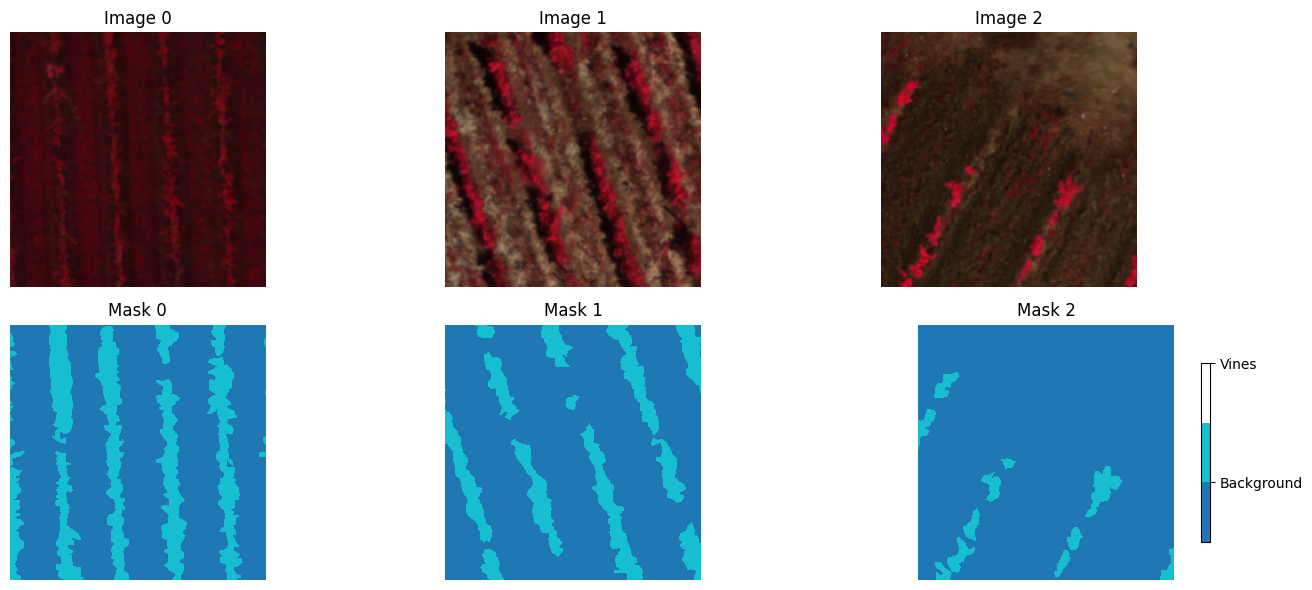

In [125]:
# Visualize a batch of training data
batch = next(iter(train_loader))
visualize_batch(
    batch, 
    num_samples=3, 
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

In [126]:
# Load pretrained ViT backbone
vit_backbone = load_pretrained_vit(
    checkpoint_path=CONFIG["pretrained_checkpoint"],
    in_channels=CONFIG["in_channels"]
)
print(f"Loaded ViT backbone with feature dimension: {vit_backbone.num_features}")

# Create segmentation model
model = ViTSegmentationModel(
    backbone=vit_backbone,
    num_classes=CONFIG["num_classes"],
    img_size=CONFIG["img_size"],
    lr=CONFIG["lr"],
    weight_decay=CONFIG["weight_decay"]
)



Loaded ViT backbone with feature dimension: 384


In [127]:
# Create UnfreezeBackboneCallback
class UnfreezeBackboneCallback(pl.Callback):
    def __init__(self, unfreeze_after=10):
        super().__init__()
        self.unfreeze_after = unfreeze_after
        
    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch == self.unfreeze_after:
            print(f"Unfreezing backbone at epoch {trainer.current_epoch}")
            pl_module.unfreeze_backbone()

In [130]:
# Create callbacks
# Create callbacks
from pytorch_lightning.callbacks import RichProgressBar

checkpoint_callback = ModelCheckpoint(
    dirpath="segmentation_checkpoints",
    filename="vits_1{epoch:02d}-{val_loss:.4f}",
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    save_last=True
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")
unfreeze_callback = UnfreezeBackboneCallback(unfreeze_after=CONFIG["unfreeze_backbone_after"])

# Create logger (you can use either WandbLogger or TensorBoardLogger)
# Comment out if you don't want to use wandb
wandb_logger = WandbLogger(project="ViT-Segmentation", log_model=False)

# Create trainer
trainer = pl.Trainer(
    max_epochs=CONFIG["epochs"],
    accelerator="auto",  # Uses GPU if available
    devices=1,
    callbacks=[checkpoint_callback, lr_monitor, unfreeze_callback, RichProgressBar()],
    logger=wandb_logger,  # Comment out if not using wandb
    log_every_n_steps=10
)
param_stats = print_model_params(model)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Layer                                       Trainable Non-trainable
----------------------------------------------------------------------
feature_extractor.vit.cls_token                     0          384
feature_extractor.vit.pos_embed                     0       75,648
feature_extractor.vit.patch_embed.proj.weight            0      393,216
feature_extractor.vit.patch_embed.proj.bias            0          384
feature_extractor.vit.blocks.0.norm1.weight            0          384
feature_extractor.vit.blocks.0.norm1.bias            0          384
feature_extractor.vit.blocks.0.attn.qkv.weight            0      442,368
feature_extractor.vit.blocks.0.attn.qkv.bias            0        1,152
feature_extractor.vit.blocks.0.attn.proj.weight            0      147,456
feature_extractor.vit.blocks.0.attn.proj.bias            0          384
feature_extractor.vit.blocks.0.norm2.weight            0          384
feature_extractor.vit.blocks.0.norm2.bias            0          384
feature_extractor.v

epoch,▁▂▂▁▂▃▅▆▇█
lr-AdamW,█████▁▁▁▁▁▁▁▁
train_loss,▁
trainer/global_step,▁▁▁▄▅▆▇█▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅
val_accuracy,█▆███▁▁▅▃
val_loss,▃█▁▁▁▁▁▁▁
epoch,6
lr-AdamW,0.00015
train_loss,0.71339
trainer/global_step,7
val_accuracy,0.5769


In [131]:
# Train the model
trainer.fit(model, train_loader, val_loader)
import wandb
wandb.finish()

Epoch 99/99 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s v_num: b86h train_loss: 0.347       
                                                                               val_loss: 0.613 val_accuracy: 0.714 

`Trainer.fit` stopped: `max_epochs=100` reached.


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
lr-AdamW,██████████▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▂▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
val_accuracy,▁█▆▆▅█▇█▅▇▇▇▇▇██████████████████████████
val_loss,▇█▆▄▅▂▃▂▃▇▃▆▃▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
lr-AdamW,0.0
train_loss,0.34696
trainer/global_step,99
val_accuracy,0.71422


C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.6156
Accuracy: 0.7115
Total F1 Score (micro-avg): 0.7115
Mean IoU: 0.4446

Per-class metrics:
Background:
  Precision: 0.7858
  Recall: 0.8432
  F1 Score: 0.8087
  IoU: 0.6816
Vines:
  Precision: 0.4033
  Recall: 0.2923
  F1 Score: 0.3301
  IoU: 0.2076

Confusion Matrix:
tensor([[3046062,  539045],
        [ 851873,  430092]], device='cuda:0')


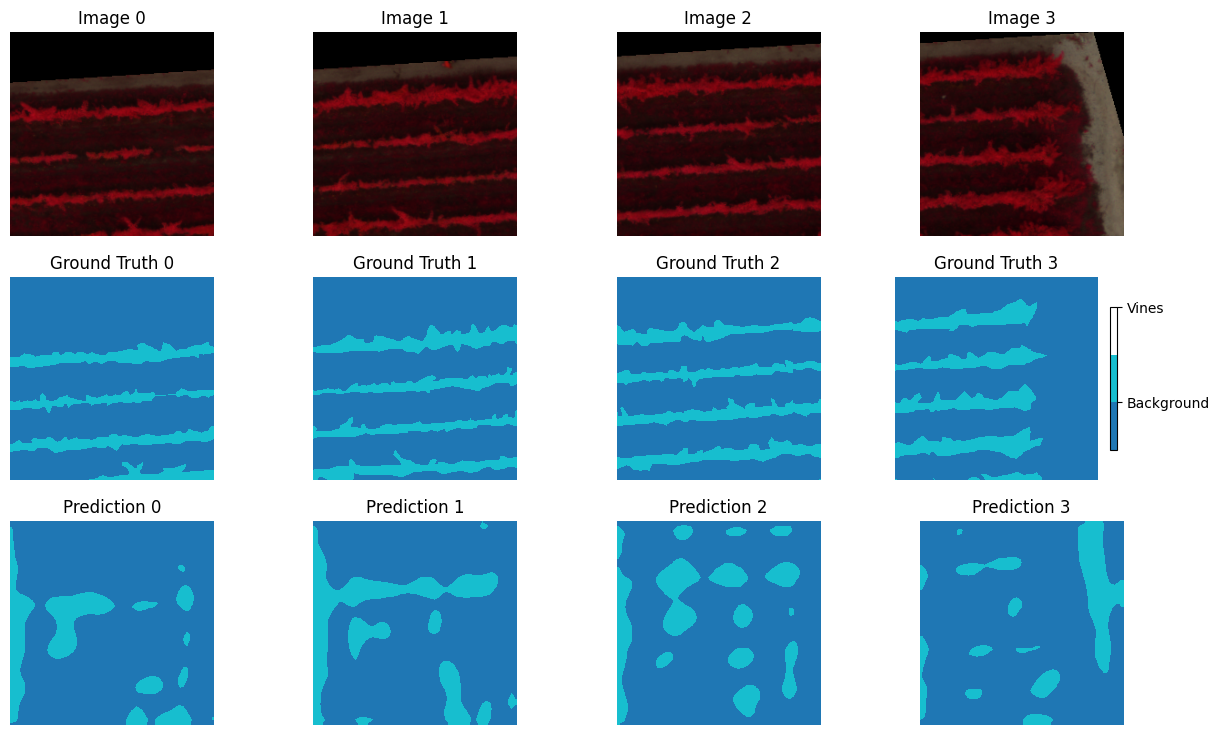

Loaded best model from C:\Users\judoj\Documents\programming\multi_ssl\notebooks\segmentation_checkpoints\last-v22.ckpt


C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.5320
Accuracy: 0.7792
Total F1 Score (micro-avg): 0.7792
Mean IoU: 0.5101

Per-class metrics:
Background:
  Precision: 0.9852
  Recall: 0.7709
  F1 Score: 0.8598
  IoU: 0.7614
Vines:
  Precision: 0.2738
  Recall: 0.8529
  F1 Score: 0.4040
  IoU: 0.2588

Confusion Matrix:
tensor([[5563890, 1674839],
        [  86282,  552621]], device='cuda:0')


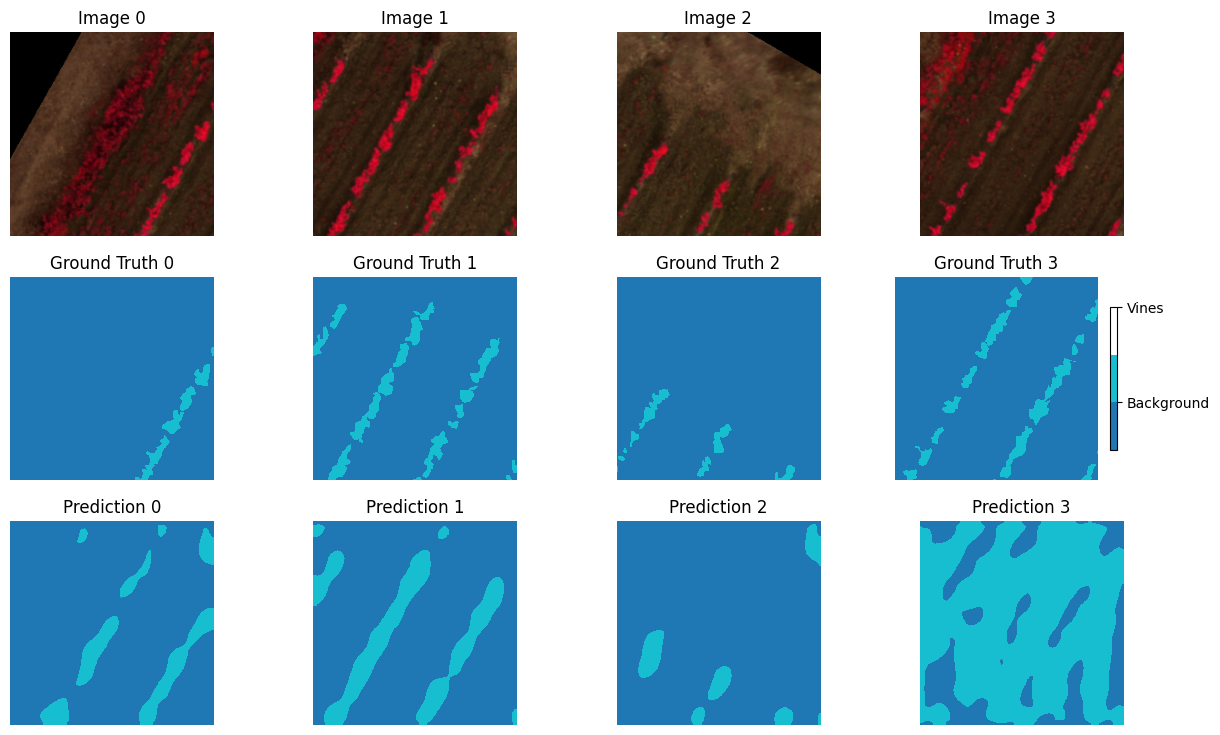

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.4639
Accuracy: 0.8510
Total F1 Score (micro-avg): 0.8510
Mean IoU: 0.6669

Per-class metrics:
Background:
  Precision: 0.9391
  Recall: 0.8721
  F1 Score: 0.9029
  IoU: 0.8245
Vines:
  Precision: 0.6013
  Recall: 0.7854
  F1 Score: 0.6691
  IoU: 0.5093

Confusion Matrix:
tensor([[4944635,  724944],
        [ 324508, 1080729]], device='cuda:0')


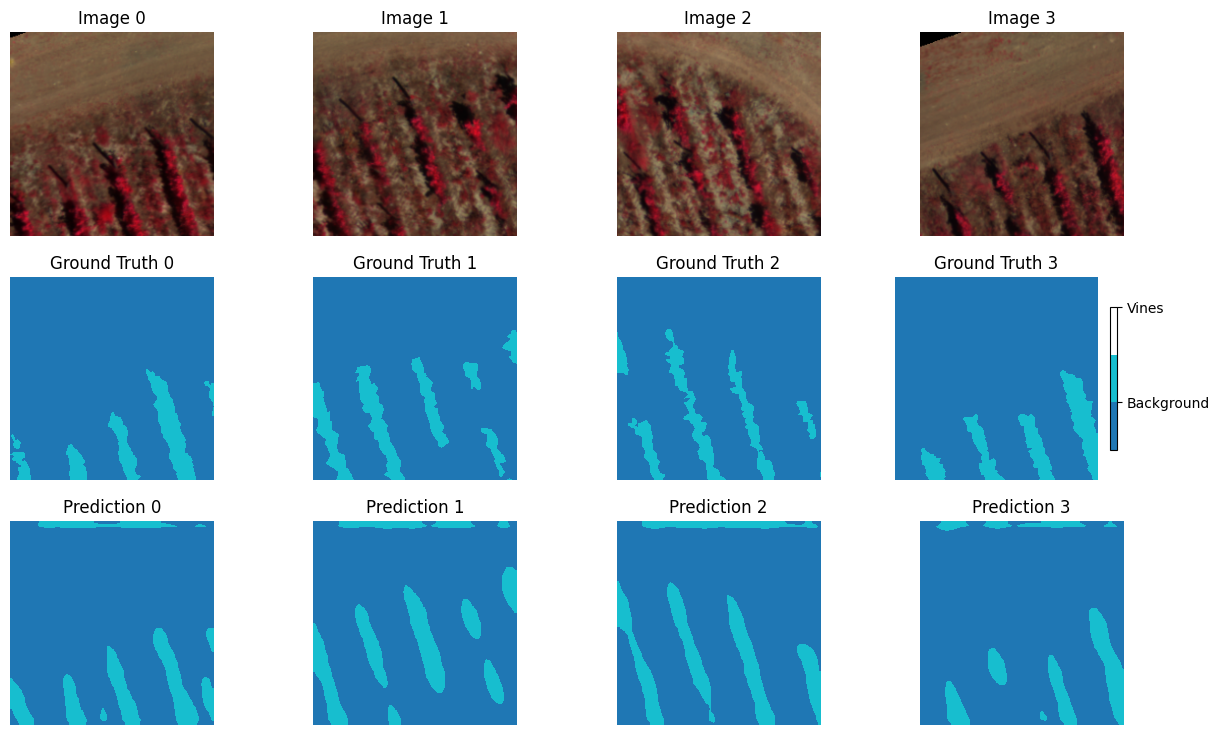

In [132]:
# Load the best model
device = "cuda"

best_model_path = checkpoint_callback.last_model_path
best_model = ViTSegmentationModel.load_from_checkpoint(best_model_path, 
                                                        backbone=vit_backbone.to("cpu"),)
best_model.to(device)
best_model.eval()
uber_test_results_e2 = best_model.test(val_loader)

visualize_predictions(
    model=best_model,
    dataloader=val_loader,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

print(f"Loaded best model from {best_model_path}")
uber_test_results_v = best_model.test(test_loader_v)


visualize_predictions(
    model=best_model,
    dataloader=test_loader_v,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

uber_test_results_q = best_model.test(test_loader_q)

visualize_predictions(
    model=best_model,
    dataloader=test_loader_q,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

In [ ]:
# Save just the state dict for easier loading in production
model_state_dict_path = "segmentation_checkpoints/model_state_dict.pth"
torch.save(best_model.state_dict(), model_state_dict_path)
print(f"Saved model state dict to {model_state_dict_path}")